# Objectives
In this Notebook, we will learn to apply a famous object detection algorithm on a labeled data set in order to detect rumex plants.

After going through this notebook, you will be able to:
- Download an image dataset from Azure DataStore and/or Labelbox.
- Inspect and clean the annotations data.
- Create a custom ```Dataset``` class to feed data to computer vision models in Pytorch.
- Create a training workflow for any object detection algorithm.
- Detect overtfitting.
- Save the model in pth format and then reuse it later on.

# Requirements

This notebook should use torchvision and torch versions that are compatible with each other. For more information, visit [this link](https://pypi.org/project/torchvision/).

For demonstration purposes, we use the torch version 1.12.1 and the torchvision 0.13.1. However, users may install and use other versions.

In [2]:
#shell commands
#create a conda environment (or activate the env azureml_py38_PT_TF)
#pip install torch==1.12.1 
#pip install torchvision==0.13.1
#pip install -U azureml-fsspec mltable

In [3]:
#Env: azureml_py38_PT_TF
import torch
import torchvision
print('The version of PyTorch is {}'.format(torch.__version__))
print('The version of Torchvision is {}'.format(torchvision.__version__))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('There are {} cuda devices'.format(torch.cuda.device_count()))
print('Used device is {}'.format(device))

The version of PyTorch is 1.12.1
The version of Torchvision is 0.13.1
There are 1 cuda devices
Used device is cuda


# Common imports
The below improts are encountered in most of the computer vision projects. Though, you may need to adapt them according to your needs.

In [4]:
#Imports
import json, os, random
random.seed(1985)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import random


from tqdm import tqdm
from matplotlib.patches import Rectangle
from PIL import Image

from torch_snippets import *

from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# Downloading the images from an Azure dataset
Before working with dataset in Azure ML, one should upload data to Azure Datastores. This could be done using the AZ CLI or the Microsoft Azure Explorer.

If you use the Microsoft Azure Explorer in the confederation network, you have to ask the IT service for a couple of digital certificates that you install on the machine in addition to tweaking a couple of settings in the software:
- The proxy: agsad.admin.ch
- The port: 8080

Once you upload the data, you can go to the datastore to check if they are there. To access the data, you need to download them from-within Azure via a small python code. 

To get the below code with the **old Dataset Feature**, browse  and click on consume as shown below:

![An image showing how we can easily get the code to consume the dataset using the old DataSets feature.](notebook_images/data_consume.png)

To get the below code with the **DataSotre Feature**, browse  and click on consume as shown below (and then click on copy usage code):

![An image showing how we can easily get the code to consume the dataset using the new DataStore feature.](notebook_images/data_consume_new.png)



In [5]:
#Downloading the data from Azure data store
# azureml-core of version 1.0.72 or higher is required

'''
from azureml.core import Workspace, Dataset, Datastore
subscription_id = '78b4d5f1-fca5-4af5-b686-34747c61c20f'
resource_group = 'computer_vision_resource_group'
workspace_name = 'upskilling_workspace_dp'
  
workspace = Workspace(subscription_id, resource_group, workspace_name)
  
datastore = Datastore.get(workspace, "workspaceblobstore")
dataset = Dataset.File.from_files(path=(datastore, 'rumex_labelbox/images'))
dataset.download(target_path='../../data/rumex/images', overwrite=True)
'''

'\nfrom azureml.core import Workspace, Dataset, Datastore\nsubscription_id = \'78b4d5f1-fca5-4af5-b686-34747c61c20f\'\nresource_group = \'computer_vision_resource_group\'\nworkspace_name = \'upskilling_workspace_dp\'\n  \nworkspace = Workspace(subscription_id, resource_group, workspace_name)\n  \ndatastore = Datastore.get(workspace, "workspaceblobstore")\ndataset = Dataset.File.from_files(path=(datastore, \'rumex_labelbox/images\'))\ndataset.download(target_path=\'../../data/rumex/images\', overwrite=True)\n'

# Example for downloading data from another source
Alternatively (probably not always the case), we can download data from other sources using the ```wget``` linux tool.
- The ```!``` is to execute a bash command from the notebook.
- The ```{}``` around the ```link``` and ```image_name``` are used because these are variables not constants

In [6]:
#Download annotations from labelbox (public data set)
#Need 7-10 min
'''
annotations = pd.read_csv(os.path.join(annotations_home, 'annotations.csv'))
os.chdir(images_home)
for link in tqdm(annotations['Labeled Data']):
    image_name = link.split('-')[-1]
    !wget {link} -O {image_name} 
os.chdir(notebook_home)
'''

"\nannotations = pd.read_csv(os.path.join(annotations_home, 'annotations.csv'))\nos.chdir(images_home)\nfor link in tqdm(annotations['Labeled Data']):\n    image_name = link.split('-')[-1]\n    !wget {link} -O {image_name} \nos.chdir(notebook_home)\n"

# Configuring some pathes to make it easier to call images and annotations

In [7]:
#The pathes on AzureML are a bit strange
full_path = os.getcwd().split('/')
#This will adapt the user name to your specific machine
home = os.path.join(os.path.expanduser('~'), 'cloudfiles/code/Users/' + full_path[11])
print('Home Directory - Full Path: {}\n'.format(home))

#The Notebook directory
notebook_home = os.path.join(home, 'computer_vision_with_azure_course/1_object_detection')
print('Notebbok Directory: {}\n'.format(notebook_home))

#The Notebook directory
images_home = os.path.join(home, 'data/rumex/images')
print('Images Directory: {}\n'.format(images_home))

#The Notebook directory
annotations_home = os.path.join(home, 'computer_vision_with_azure_course/1_object_detection/annotations')
print('Annotations Directory: {}\n'.format(annotations_home))

Home Directory - Full Path: /home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope

Notebbok Directory: 
/home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope/computer_vision_with_azure_course/1_object_detection

Images Directory: /home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope/data/rumex/images

Annotations Directory: 
/home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope/computer_vision_with_azure_course/1_object_detection/
annotations

# Defining a set of functions to work with data
- ```load_clean_annotations```: will load the annotations file into a dataframe and clean records of un-annotated or empty annotations images.
- ```get_bboxes```: Returns a list of bounding boxes of a specific image from the annotations dataframe.

#### The function: load_clean_annotations

In [8]:
#Format labels and images
#We will read the labels and choose the necessary informations

def load_clean_annotations(file):
    '''
    Returns the rumex annotations dataframe with the necessary two columns (bboxes annotations and image name).
    Specific to a labelbox dataframe with the setting we configured.

            Parameters:
                    None

            Returns:
                    annotations (pandas): pandas dataframe
    '''

    # Read the annotations cSV
    annotations = pd.read_csv(os.path.join(annotations_home, file))

    #Select the two useful columns
    annotations = annotations[['Label', 'External ID']]

    #Remove records with Label = 'Skip' or '{"bild_enthaelt_ampfer":"nein"}' or '{"bild_enthaelt_ampfer":"ja"}'
    annotations = annotations[annotations['Label'] != 'Skip']
    annotations = annotations[annotations['Label'] != '{"bild_enthaelt_ampfer":"nein"}'] #Contains no information
    annotations = annotations[annotations['Label'] != '{"bild_enthaelt_ampfer":"ja"}'] #Contains no information

    #Remove annotations for images that do not exist (or not downloaded for some reason)
    list_image = [i for i in os.listdir(images_home) if i.endswith('png') or i.endswith('jpg') or i.endswith('PNG') or i.endswith('JPG') or i.endswith('JPEG')]
    annotations = annotations[annotations['External ID'].isin(list_image)]

    #Reset the index of the dataframe
    annotations.reset_index(inplace = True, drop=True)

    #Return the dataframe
    return annotations

In [9]:
#Test the function
df = load_clean_annotations('annotations.csv')
df.head()

Label   External ID
0  {"Wurzelpunkt":[{"geometry":{"x":821,"y":424}}...  img_2001.png
1  {"Wurzelpunkt":[{"geometry":{"x":651,"y":493}}...  img_2008.png
2  {"Wurzelpunkt":[{"geometry":{"x":545,"y":699}}...  img_2009.png
3  {"Wurzelpunkt":[{"geometry":{"x":740,"y":527}}...  img_2010.png
4  {"Wurzelpunkt":[{"geometry":{"x":697,"y":666}}...  img_2011.png

In [10]:
print(df.shape)

(470, 2)

#### Inspecting the annotations dataframe

In [11]:
#Inspecting the labels and check how we can reformat them into a list

#Example of extracting the label box coordinates from a dataframe given and image name
row = df[df['External ID'] == 'img_2200.png']

targetv1 = df['Label'].iloc[row.index[0]]
targetv2 = json.loads(targetv1)

print(targetv2)
xmin = targetv2['Ampfer'][0]['geometry'][0]['x']
print(xmin)
xmax = targetv2['Ampfer'][0]['geometry'][2]['x']
print(xmax)
ymin = targetv2['Ampfer'][0]['geometry'][0]['y']
print(ymin)
ymax = targetv2['Ampfer'][0]['geometry'][2]['y']
print(ymax)

{
    'Wurzelpunkt': [
        {'geometry': {'x': 1194, 'y': 351}},
        {'geometry': {'x': 223, 'y': 223}},
        {'geometry': {'x': 171, 'y': 129}},
        {'geometry': {'x': 762, 'y': 108}}
    ],
    'Ampfer': [
        {'geometry': [{'x': 1478, 'y': 563}, {'x': 924, 'y': 563}, {'x': 924, 'y': 152}, {'x': 1478, 'y': 152}]},
        {'geometry': [{'x': 112, 'y': 116}, {'x': 112, 'y': 319}, {'x': 329, 'y': 319}, {'x': 329, 'y': 116}]},
        {'geometry': [{'x': 10, 'y': 20}, {'x': 10, 'y': 238}, {'x': 327, 'y': 238}, {'x': 327, 'y': 20}]},
        {'geometry': [{'x': 878, 'y': 235}, {'x': 641, 'y': 235}, {'x': 641, 'y': 5}, {'x': 878, 'y': 5}]}
    ],
    'bild_enthaelt_ampfer': 'ja'
}

1478

924

563

152

#### Quick-win snippet to examplify extranting bounding boxes 

In [12]:
#Before you start the function, build it step by step manually
bboxes = []
for bbox in targetv2['Ampfer']:
    xmin = bbox['geometry'][0]['x']
    xmax = bbox['geometry'][2]['x']
    ymin = bbox['geometry'][0]['y']
    ymax = bbox['geometry'][2]['y']
    bboxes.append([xmin, ymin, xmax, ymax])
bboxes

[[1478, 563, 924, 152],
 [112, 116, 329, 319],
 [10, 20, 327, 238],
 [878, 235, 641, 5]]

#### The function: get_bboxes

In [13]:
def get_bboxes(df, name):
    '''
    Extract bounding box for an image in a dataframe.

            Parameters:
                    df: The annotations dataframe (extracted from a labelbox annotations file)
                    name: The image name

            Returns:
                    bboxes (list): a list of bounding boxes. Each bounding boxes is a list defined by [xmin, ymin, xmax, ymax]
    '''
    row = df[df['External ID'] == name]
    #print(row)
    if len(row) == 0:
        print('The image does not have annotations (it was skipped)')
        return False
    else:
        #print(row)
        targetv1 = df['Label'].iloc[row.index[0]]
        #print(targetv1)
        targetv2 = json.loads(targetv1)
        bboxes = []
        for bbox in targetv2['Ampfer']:
            x1 = bbox['geometry'][0]['x']
            x2 = bbox['geometry'][2]['x']
            y1 = bbox['geometry'][0]['y']
            y2 = bbox['geometry'][2]['y']
            #Usually, x1 should be the xmin and so on. But, depending on how the box was drawn, they may be mixed up
            xmin = min(x1, x2)
            ymin = min(y1, y2)
            xmax = max(x1, x2)
            ymax = max(y1, y2)
            bboxes.append([xmin, ymin, xmax, ymax]) #needed in this format xmin, ymin, xmax, ymax
        return bboxes

In [14]:
# A random annotations record
random_row = random.randint(0, df.shape[0])
df.iloc[random_row]['Label']

'{"Wurzelpunkt":[{"geometry":{"x":1331,"y":471}},{"geometry":{"x":1347,"y":933}}],"Ampfer":[{"geometry":[{"x":1140,"y":340},{"x":1140,"y":616},{"x":1522,"y":616},{"x":1522,"y":340}]},{"geometry":[{"x":1441,"y":1023},{"x":1265,"y":1023},{"x":1265,"y":846},{"x":1441,"y":846}]}],"bild_enthaelt_ampfer":"ja"}'

#### Testing the get_bboxes with a couple of images

In [15]:
#The bounding boxes of a randomly chosen image
list_image = os.listdir(images_home)
list_image = [i for i in os.listdir(images_home) if i.endswith('png') or i.endswith('jpg') or i.endswith('PNG') or i.endswith('JPG') or i.endswith('JPEG')]
random_image = list_image[random.randint(0, len(list_image))]
print('Chosen image: {}'.format(random_image))
get_bboxes(df, random_image)

Chosen image: img_2369.png

[[626, 458, 776, 592],
 [664, 295, 878, 464],
 [1180, 1, 1338, 85],
 [1361, 905, 1521, 1023]]

In [16]:
#The bounding boxes of a specific image
get_bboxes(df, 'img_2022.png')

[[495, 82, 1019, 599]]

In [17]:
get_bboxes(df, 'img_2000.png') #Gives False because the image is not annotated

The image does not have annotations (it was skipped)

False

# Visualizing an image with its bounding boxes

img_2031.png

[[441, 256, 870, 682], [1141, 690, 1502, 1023], [958, 19, 1234, 428]]

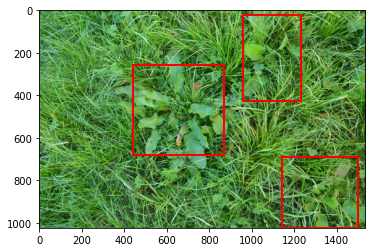

In [18]:
#Let's read and image and check if the bouding boxes are extracted correctly

# Choose an image
index = random.randint(8, len(list_image)) #problem occurs from 1 to 7 (because annotations were skipped for these images)

#What is the image name for this index
list_image = [i for i in os.listdir(images_home) if i.endswith('png') or i.endswith('jpg') or i.endswith('PNG') or i.endswith('JPG') or i.endswith('JPEG')]
imname = list_image[index]
imname = 'img_2031.png'
print(imname)
#Read image
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
im = Image.open(f'{images_home}/{imname}')
ax.imshow(im)

#Read bboxes of that specific image
bboxes = get_bboxes(df, imname)
print(bboxes)
# Create a Rectangle patch
for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
    #https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
    rect = Rectangle((xmin, ymax), xmax - xmin, ymin - ymax, linewidth=2, edgecolor='r', facecolor='none')
    # We put ymin - ymax because the coordinates of the image are inverted (check documentation)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    

#Show image with bouding boxes
plt.show()
#[xmin, ymin, xmax, ymax]

### What do you think of the annotations of the image: img_2031.png?

Best practices for annotating bounding boxes: https://www.v7labs.com/blog/bounding-box-annotation 


In [19]:
def preprocess_image(img):
    img = np.array(img) / 255.
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float() #Float32 (avoid float 64 to not flod the memory)

In [20]:
#The image as read by the PIL 
img = Image.open(f'{images_home}/{imname}').convert("RGB")
print(type(img))
#print(np.array(img).shape) #No shape function for the PIL.Image.Image
#show(img)
#Then after transforming it to array
img = np.array(img) / 255.
#show(img) #We can't divide the PIL by 255. We have to transform it to an array first
#print(np.array(img).shape) #No shape function for the PIL.Image.Image
#
img = torch.tensor(img).permute(2,0,1)  #
print(img)

#show(img)
#print(np.array(img).shape) #No shape function for the PIL.Image.Image

#Making putting the image on CUDA and transforming it to float
img.to(device).float()

<class 'PIL.Image.Image'>

tensor([[[0.1333, 0.1176, 0.1020,  ..., 0.4039, 0.4667, 0.4745],
         [0.2784, 0.2157, 0.1490,  ..., 0.5098, 0.4706, 0.4078],
         [0.4784, 0.3961, 0.2980,  ..., 0.4667, 0.3686, 0.3412],
         ...,
         [0.1098, 0.1255, 0.1373,  ..., 0.4431, 0.4431, 0.3922],
         [0.2314, 0.2392, 0.2471,  ..., 0.4353, 0.4627, 0.4157],
         [0.3216, 0.3176, 0.3176,  ..., 0.4078, 0.4510, 0.4078]],

        [[0.3176, 0.2941, 0.2706,  ..., 0.6392, 0.7569, 0.7843],
         [0.4275, 0.3725, 0.3137,  ..., 0.7647, 0.7608, 0.7059],
         [0.5882, 0.5216, 0.4549,  ..., 0.7294, 0.6275, 0.6000],
         ...,
         [0.3333, 0.3490, 0.3647,  ..., 0.6627, 0.6863, 0.6431],
         [0.4431, 0.4510, 0.4627,  ..., 0.6627, 0.7098, 0.6667],
         [0.5294, 0.5255, 0.5294,  ..., 0.6353, 0.6980, 0.6588]],

        [[0.1412, 0.1176, 0.0863,  ..., 0.1804, 0.2078, 0.2039],
         [0.2314, 0.1804, 0.1294,  ..., 0.2353, 0.1725, 0.1059],
         [0.3647, 0.3098, 0.2627,  ..., 0.1882, 0.1529, 0.1490],
         ...,
         [0.2471, 0.2549, 0.2588,  ..., 0.2706, 0.2627, 0.2078],
         [0.3843, 0.3882, 0.3804,  ..., 0.2588, 0.2863, 0.2353],
         [0.5020, 0.4941, 0.4745,  ..., 0.2314, 0.2745, 0.2275]]],
       dtype=torch.float64)

tensor([[[0.1333, 0.1176, 0.1020,  ..., 0.4039, 0.4667, 0.4745],
         [0.2784, 0.2157, 0.1490,  ..., 0.5098, 0.4706, 0.4078],
         [0.4784, 0.3961, 0.2980,  ..., 0.4667, 0.3686, 0.3412],
         ...,
         [0.1098, 0.1255, 0.1373,  ..., 0.4431, 0.4431, 0.3922],
         [0.2314, 0.2392, 0.2471,  ..., 0.4353, 0.4627, 0.4157],
         [0.3216, 0.3176, 0.3176,  ..., 0.4078, 0.4510, 0.4078]],

        [[0.3176, 0.2941, 0.2706,  ..., 0.6392, 0.7569, 0.7843],
         [0.4275, 0.3725, 0.3137,  ..., 0.7647, 0.7608, 0.7059],
         [0.5882, 0.5216, 0.4549,  ..., 0.7294, 0.6275, 0.6000],
         ...,
         [0.3333, 0.3490, 0.3647,  ..., 0.6627, 0.6863, 0.6431],
         [0.4431, 0.4510, 0.4627,  ..., 0.6627, 0.7098, 0.6667],
         [0.5294, 0.5255, 0.5294,  ..., 0.6353, 0.6980, 0.6588]],

        [[0.1412, 0.1176, 0.0863,  ..., 0.1804, 0.2078, 0.2039],
         [0.2314, 0.1804, 0.1294,  ..., 0.2353, 0.1725, 0.1059],
         [0.3647, 0.3098, 0.2627,  ..., 0.1882, 0.1529, 0.

# Creating the dataset
Creating dataset (and dataloaders) are the most important steps in the training pipeline. Pytorch (also other platforms) have standarised ways to created data sets. This is because data and annotations comes in different format, but the models accepts them in a standard format only. 
- Simple data sets could be created by overriding the ```torch.utils.data.Dataset``` class.
- Vision data sets could be created by overriding the ```torchvision.datasets.VisionDataset``` class. This class is more aligned toward where annotations such as bounding boxes, semantic segments and key points are used.
 
Two methods should be overrided:
- The ```__getitem__ ``` method: in this method, we return the image ```i``` with it bounding box or mask
- The ```__len__``` method: in this method we return the number of images in the dataset


In [21]:
#Define the Rumex Dataset

class RumexDataSetLabelBox(Dataset):
    def __init__(self, images_home, annotations_df):
        
        self.root = images_home
        self.list_image = list(annotations_df['External ID'])
        #print(self.list_image)
        self.datalength = len(self.list_image)
   
    def __getitem__(self, index):
        #This should return a tuple containing: the image in tensor format and the list of bounding boxes in the image
        # Given an index, we should be able to read the image from the root folder and its corresponding Bboxes
        #Bboxes should be in the following format [xmin, ymin, xmax, ymax]

        imname = self.list_image[index]
        img_path = os.path.join(self.root, imname) 
        img = Image.open(img_path).convert("RGB")

        bboxes = get_bboxes(annotations_df, imname)
        
        image_id = torch.tensor([index])
        #area = [ (b[3] - b[1]) * (b[2] - b[0]) for b in bboxes]

        num_rumex = len(bboxes)
        labels = torch.ones((num_rumex,), dtype=torch.int64) #Target labels should be of type int64
        target = {}
        

        target["boxes"] = torch.Tensor(bboxes)
        target["labels"] =  labels

        img = preprocess_image(img)

        return img, target

    def __len__(self):
        return self.datalength



In [22]:
annotations_df = load_clean_annotations('annotations.csv')
rumex_dataset = RumexDataSetLabelBox(images_home, annotations_df)

sample_data = rumex_dataset[1]
sample_data[1], sample_data[0]

({'boxes': tensor([[ 493.,  400.,  856.,  612.],
          [ 386.,  203.,  765.,  568.],
          [ 301.,  548.,  522.,  750.],
          [ 327.,  267.,  513.,  420.],
          [ 823.,   31., 1056.,  220.],
          [ 183.,  134.,  505.,  383.],
          [ 690.,  525., 1103.,  730.],
          [ 516.,  330.,  928.,  566.],
          [  75.,  475.,  284.,  720.],
          [ 236.,  868.,  537., 1023.],
          [ 117.,   23.,  559.,  207.],
          [ 495.,    0.,  678.,   99.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])},
 tensor([[[0.2078, 0.2118, 0.1961,  ..., 0.3569, 0.3255, 0.3961],
          [0.1137, 0.2039, 0.2000,  ..., 0.3176, 0.3608, 0.6039],
          [0.0745, 0.1216, 0.1922,  ..., 0.2980, 0.5529, 0.8275],
          ...,
          [0.3569, 0.3529, 0.3294,  ..., 0.2706, 0.2706, 0.2627],
          [0.3569, 0.3490, 0.3294,  ..., 0.2980, 0.2980, 0.2902],
          [0.3569, 0.3529, 0.3255,  ..., 0.2667, 0.2667, 0.2588]],
 
         [[0.3765, 0.3843, 0.3804,  

In [23]:
#Print the image shape
sample_data[0].shape

torch.Size([3, 1024, 1536])

# Some more utility functions for data zipping, transformation and model saving

In [24]:
#Reference
#https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

    #About ZIP:
    #It 'zips' tupples so that we can iterate over them in parallel 
    #(https://docs.python.org/3/library/functions.html#zip)
    #The two iterables in our case are: target and features
    #This is necessary because not all targets have the same size (same # of bboxes)
    #We give collate as an argument to the dataloader to tell DataLoader how to collate 
    #the feature/targets together.  

# define the training tranforms
def get_train_transform():
    return transforms.Compose([
        transforms.Flip(0.5),
        transforms.RandomRotate90(0.5),
        transforms.ToTensor(),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return transforms.Compose([
        transforms.ToTensor(),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })



def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/last_model.pth')

def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')

    plt.close('all')


# Creating train/test/val datasets and Dataloaders
 
We can either create 3 separete datasets (training, testing and validation) or create one dataset and then split 
it afterward. I prefer to create one dataset and then split it afterwards. This will help randomizing the experiments at each run.


In [25]:
sample_data[0]

tensor([[[0.2078, 0.2118, 0.1961,  ..., 0.3569, 0.3255, 0.3961],
         [0.1137, 0.2039, 0.2000,  ..., 0.3176, 0.3608, 0.6039],
         [0.0745, 0.1216, 0.1922,  ..., 0.2980, 0.5529, 0.8275],
         ...,
         [0.3569, 0.3529, 0.3294,  ..., 0.2706, 0.2706, 0.2627],
         [0.3569, 0.3490, 0.3294,  ..., 0.2980, 0.2980, 0.2902],
         [0.3569, 0.3529, 0.3255,  ..., 0.2667, 0.2667, 0.2588]],

        [[0.3765, 0.3843, 0.3804,  ..., 0.6157, 0.5451, 0.6000],
         [0.2745, 0.3725, 0.3804,  ..., 0.5569, 0.5647, 0.7961],
         [0.2314, 0.2863, 0.3725,  ..., 0.5137, 0.7294, 0.9765],
         ...,
         [0.5176, 0.5137, 0.4902,  ..., 0.4118, 0.4118, 0.4039],
         [0.5020, 0.4941, 0.4667,  ..., 0.4667, 0.4667, 0.4588],
         [0.4745, 0.4667, 0.4353,  ..., 0.4745, 0.4745, 0.4667]],

        [[0.0706, 0.0824, 0.0824,  ..., 0.1412, 0.0510, 0.1020],
         [0.0157, 0.0902, 0.0863,  ..., 0.0902, 0.0784, 0.3020],
         [0.0039, 0.0353, 0.0863,  ..., 0.0510, 0.2471, 0.

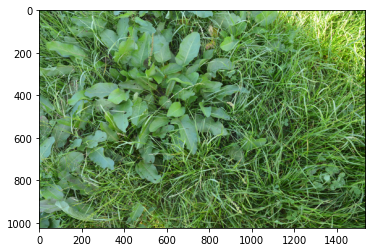

In [26]:
plt.imshow(sample_data[0].cpu().permute(1,2,0))

In [27]:
sample_data[0].shape

torch.Size([3, 1024, 1536])

In [28]:
sample_data[1]

{'boxes': tensor([[ 493.,  400.,  856.,  612.],
         [ 386.,  203.,  765.,  568.],
         [ 301.,  548.,  522.,  750.],
         [ 327.,  267.,  513.,  420.],
         [ 823.,   31., 1056.,  220.],
         [ 183.,  134.,  505.,  383.],
         [ 690.,  525., 1103.,  730.],
         [ 516.,  330.,  928.,  566.],
         [  75.,  475.,  284.,  720.],
         [ 236.,  868.,  537., 1023.],
         [ 117.,   23.,  559.,  207.],
         [ 495.,    0.,  678.,   99.]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

# Spliting the dataset

In [29]:
n_datapoints = len(rumex_dataset)
n_train = int(0.7 * n_datapoints)
n_test =  int(0.15 * n_datapoints)
n_val = n_datapoints - n_train - n_test #Try int(0.15 * n_datapoints) and see what happens
train_data, test_data, val_data = random_split(rumex_dataset, [n_train, n_test, n_val])

#In some situation, you might need to create each datasets separately rather than deriving them from the main dataset. This happens when data are 
#already splited into train/test/val folders and annotations also splitted.

In [30]:
print(f'Number of images in the training dataset is: {len(train_data)}')
print(f'Number of images in the training dataset is: {len(test_data)}')
print(f'Number of images in the training dataset is: {len(val_data)}')

Number of images in the training dataset is: 329

Number of images in the training dataset is: 70

Number of images in the training dataset is: 71

# Dataloaders
Iterable wrappers around the datasets

In [31]:
train_loader = DataLoader(
        train_data,
        batch_size=8,
        shuffle=False,
        collate_fn=collate_fn
    )
test_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)
val_loader = DataLoader(
        val_data,
        batch_size=8,
        shuffle=False,
        collate_fn=collate_fn
    )

#train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)


In [32]:
a_sample = next(iter(train_loader))

In [33]:
a_sample[0][0]

tensor([[[0.1961, 0.2078, 0.1961,  ..., 0.1333, 0.0980, 0.0941],
         [0.1765, 0.1922, 0.1922,  ..., 0.1333, 0.1020, 0.0902],
         [0.1725, 0.1725, 0.1569,  ..., 0.1804, 0.1569, 0.1373],
         ...,
         [0.2627, 0.2902, 0.3020,  ..., 0.1569, 0.2902, 0.4196],
         [0.2706, 0.2902, 0.2902,  ..., 0.1412, 0.2706, 0.4196],
         [0.2549, 0.2706, 0.2627,  ..., 0.1843, 0.2902, 0.4157]],

        [[0.4510, 0.4510, 0.4235,  ..., 0.3059, 0.2392, 0.2235],
         [0.4353, 0.4392, 0.4235,  ..., 0.3059, 0.2471, 0.2196],
         [0.4353, 0.4196, 0.3922,  ..., 0.3529, 0.2980, 0.2667],
         ...,
         [0.4784, 0.5020, 0.5137,  ..., 0.2157, 0.3373, 0.4627],
         [0.4824, 0.5020, 0.5020,  ..., 0.2039, 0.3176, 0.4627],
         [0.4667, 0.4824, 0.4745,  ..., 0.2588, 0.3490, 0.4706]],

        [[0.0235, 0.0392, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0118, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.

# Modelling (Defining the model / Model inspection)

In [34]:
#Model fastrcnn
from torchvision.models import resnet50, ResNet50_Weights

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True) #pretrained=True is deprecated
model

# The first 11 convolutional layers are freezed by default
'''
Freezed
torch.Size([64, 3, 7, 7])
Freezed
torch.Size([64, 64, 1, 1])
Freezed
torch.Size([64, 64, 3, 3])
Freezed
torch.Size([256, 64, 1, 1])
Freezed
torch.Size([256, 64, 1, 1])
Freezed
torch.Size([64, 256, 1, 1])
Freezed
torch.Size([64, 64, 3, 3])
Freezed
torch.Size([256, 64, 1, 1])
Freezed
torch.Size([64, 256, 1, 1])
Freezed
torch.Size([64, 64, 3, 3])
Freezed
'''

#Starting the 12th convolutional layer, (starting layer2), all parameters are trainable
# Layer3: 13 convolutional layers
# Layer4: 10 convolutional layers
# FPN: 8 convolutional layers
# RPN: 3 conv layers + 4 FC layers

'''
torch.Size([256, 64, 1, 1])
Trainable
'''


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'\ntorch.Size([256, 64, 1, 1])\nTrainable\n'

In [35]:
#Check the similarities between the resnet network and the fasterRCNN network with a resnet backbone
from torchvision.models import resnet50, ResNet50_Weights
resnet50(weights=ResNet50_Weights.DEFAULT)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# What is different between the RestNet network and the FasterRCNN Network with a resnet Backbone?
- FasterRCNN = Normalization layer + Resnet (- avgpool and FC layer for classification) + Feature Pyramid Network + Region Proposal Network.


Feature Pyramid Network | Region Proposal Network
- | - 
![alt](notebook_images/fpn.png) | ![alt](notebook_images/rpn.png)


In [36]:
#We can access each layer from the pre-built model as follow model.<layer_name>
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

In [37]:
#We can access each sublayer (... and sub sub layer) from the pre-built model as follow model.<layer_name>.<sub_layer_name>
model.roi_heads.box_roi_pool

MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)

This model was created to predict 91 class of object and their corresponding bounding boxes 91*4 = 364
```
    (box_predictor): FastRCNNPredictor(
      (cls_score): Linear(in_features=1024, out_features=91, bias=True)
      (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
```
We need to change the model so that it is able to localize our ```n_classes```. In our case, we have background and Rumex. So, 2 classes.

This is possible by creating replacing the whole ROI head.

In [38]:
# get the number of input features 
in_features = model.roi_heads.box_predictor.cls_score.in_features

# define a new head for the detector with required number of classes
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#Question: Why can't we change directly the output_features like this: model.roi_heads.box_predictor.cls_score.out_features = 4
#Answer: because this will not change the output features of the bbox pred. Therefore, we need to change both (cls_score and bbox_pred score) 
#Separately. It's a good habit to replace the whole block rather than fixing only one part to avoid possible errors

model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

# Functions to inspect the model

Run the help function of ```torchvision.models.detection.faster_rcnn``` and have a look on the **BIG** documentation that it has (Other architectures very similar documentation):
- Inspect the arguments of the class.
- Inspect the methods of the class.

In [39]:
help(torchvision.models.detection.faster_rcnn)

Help on module torchvision.models.detection.faster_rcnn in torchvision.models.detection:

NAME
    torchvision.models.detection.faster_rcnn

CLASSES
    torchvision.models._api.WeightsEnum(torchvision._utils.StrEnum)
        FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
        FasterRCNN_MobileNet_V3_Large_FPN_Weights
        FasterRCNN_ResNet50_FPN_V2_Weights
        FasterRCNN_ResNet50_FPN_Weights
    torchvision.models.detection.generalized_rcnn.GeneralizedRCNN(torch.nn.modules.module.Module)
        FasterRCNN
    
    class FasterRCNN(torchvision.models.detection.generalized_rcnn.GeneralizedRCNN)
     |  FasterRCNN(backbone, num_classes=None, min_size=800, max_size=1333, image_mean=None, image_std=None, rpn_anchor_generator=None, rpn_head=None, rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000, rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000, rpn_nms_thresh=0.7, rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3, rpn_batch_size_per_image=256, rpn_positive_fraction=0

In [40]:
# 3 ways to access the structures (layers and parameters)

# All the structure
print('Model Parameters')
print(model.parameters)
print('==========================================================================================')

#An iterator over all the 
print('This is an iterator: we can use it with a for loop for example.')
print(model.parameters())
print('==========================================================================================')

#An iterator over all the 
print('Print as a list')
print(list(model.parameters()))
print('==========================================================================================')

#An iterator over all the 
print('Print print the next parameter')
print(next(model.parameters()).numel())
print('==========================================================================================')



Model Parameters

<bound method Module.parameters of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(

==========================================================================================

This is an iterator: we can use it with a for loop for example.

<generator object Module.parameters at 0x7fa8d628d970>

==========================================================================================

Print as a list

[
    Parameter containing:
tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7619e-01],
          ...,
          [ 2.8818e-02,  1.3665e-02, -8.3825e-02,  ..., -3.8081e-01,
           -3.0414e-01, -1.3966e-01],
          [ 8.2868e-02,  1.3864e-01,  1.5241e-01,  ..., -5.1232e-03,
           -1.2435e-01, -1.2967e-01],
          [-7.2789e-03,  7.7021e-02,  1.3999e-01,  ...,  1.8427e-01,
            1.1144e-01,  2.3438e-02]],

         [[-1.8311e-02, -5.6424e-03,  8.7224e-03,  ...,  2.5775e-02,
            2.6431e-02, -3.9914e-03],
          [-1.0098e-02,  4.1615e-03,  4.9730e-02,  ...,  1.2447e-01,
            1.1950e-01,  1.1198e-01],
          [-6.3478e-02, -1.0146e-01, -9.8343e-02,  ...,  1.0630e-01,
            1.3982e-01,  1.4942e-01],
          ...,
          [ 2.5810e-02,  1.0501e-02, -7.4578e-02,  ..., -3.1385e-01,
           -2.5495e-01, -1.2276e-01],
          [ 7.3049e-02,  1.1170e-01,  1.3093e-01,  ..., -6.4584e-03,
           -1.2548e-01, -1.2446e-01],
          [-6.4210e-03,  6.6393e-02,  1.2177e-01,  ...,  1.9075e-01,
            1.1415e-01,  2.3337e-02]]],


        [[[ 6.8609e-02,  3.7955e-02,  5.3564e-02,  ...,  2.6891e-02,
            4.8369e-02,  6.3264e-02],
          [ 6.1844e-02,  1.8407e-02,  2.2672e-02,  ..., -4.8800e-02,
           -2.2130e-02, -5.7287e-03],
          [ 5.6553e-02,  1.4883e-02, -6.9185e-03,  ..., -1.2919e-01,
           -9.5042e-02, -5.8671e-02],
          ...,
          [ 2.3802e-02, -5.2273e-02, -1.1277e-01,  ..., -2.5591e-01,
           -2.4049e-01, -2.0315e-01],
          [ 5.6221e-02, -2.1824e-02, -5.9207e-02,  ..., -2.3806e-01,
           -1.9836e-01, -1.6578e-01],
          [ 5.9635e-02,  3.7172e-03, -4.8716e-02,  ..., -1.6098e-01,
           -1.4336e-01, -1.0251e-01]],

         [[-9.9041e-02, -7.2129e-02, -7.2748e-02,  ..., -3.6232e-02,
           -8.1876e-02, -8.8119e-02],
          [-7.0621e-02, -3.9200e-02, -1.0514e-02,  ...,  5.9519e-02,
            2.5891e-02, -1.3287e-02],
          [-9.3963e-02, -2.5318e-02,  3.0725e-02,  ...,  2.0738e-01,
            1.6162e-01,  8.6865e-02],
          ...,
          [-3.9978e-02,  6.4148e-02,  1.6941e-01,  ...,  4.5814e-01,
            3.7839e-01,  2.5870e-01],
          [-6.4985e-02,  1.3637e-02,  1.3008e-01,  ...,  3.6661e-01,
            3.2009e-01,  2.0442e-01],
          [-1.0433e-01, -2.7216e-02,  4.1199e-02,  ...,  2.2797e-01,
            1.8622e-01,  1.1854e-01]],

         [[ 4.2717e-02,  4.7269e-02,  1.7798e-02,  ...,  3.4693e-02,
            2.8595e-02,  4.3173e-02],
          [ 3.6308e-02,  3.3459e-02, -1.2449e-03,  ...,  4.2910e-03,
            4.6513e-03,  2.4962e-02],
          [ 2.3541e-02,  1.6826e-02, -1.5325e-02,  ..., -7.2865e-02,
           -7.2030e-02, -2.3747e-02],
          ...,
          [ 2.9623e-02,  1.8176e-03, -7.9559e-02,  ..., -1.8138e-01,
           -1.6950e-01, -6.1192e-02],
          [ 3.5233e-02, -8.5295e-03, -5.4253e-02,  ..., -1.5068e-01,
           -1.2747e-01, -4.5340e-02],
          [ 5.4786e-02,  3.9805e-02, -1.0473e-02,  ..., -4.2332e-02,
           -5.2220e-02,  5.1277e-04]]],


        [[[ 7.

==========================================================================================

Print print the next parameter

9408

==========================================================================================

In [41]:
# Print the names of parameters not requiring grad (freezed)
for name, parameter in model.named_parameters():
    if not parameter.requires_grad:
        print(name)

backbone.body.conv1.weight

backbone.body.layer1.0.conv1.weight

backbone.body.layer1.0.conv2.weight

backbone.body.layer1.0.conv3.weight

backbone.body.layer1.0.downsample.0.weight

backbone.body.layer1.1.conv1.weight

backbone.body.layer1.1.conv2.weight

backbone.body.layer1.1.conv3.weight

backbone.body.layer1.2.conv1.weight

backbone.body.layer1.2.conv2.weight

backbone.body.layer1.2.conv3.weight

In [42]:
# Print the names of parameters  requiring grad (not-freezed)
for name, parameter in model.named_parameters():
    if parameter.requires_grad:
        print(name)

backbone.body.layer2.0.conv1.weight

backbone.body.layer2.0.conv2.weight

backbone.body.layer2.0.conv3.weight

backbone.body.layer2.0.downsample.0.weight

backbone.body.layer2.1.conv1.weight

backbone.body.layer2.1.conv2.weight

backbone.body.layer2.1.conv3.weight

backbone.body.layer2.2.conv1.weight

backbone.body.layer2.2.conv2.weight

backbone.body.layer2.2.conv3.weight

backbone.body.layer2.3.conv1.weight

backbone.body.layer2.3.conv2.weight

backbone.body.layer2.3.conv3.weight

backbone.body.layer3.0.conv1.weight

backbone.body.layer3.0.conv2.weight

backbone.body.layer3.0.conv3.weight

backbone.body.layer3.0.downsample.0.weight

backbone.body.layer3.1.conv1.weight

backbone.body.layer3.1.conv2.weight

backbone.body.layer3.1.conv3.weight

backbone.body.layer3.2.conv1.weight

backbone.body.layer3.2.conv2.weight

backbone.body.layer3.2.conv3.weight

backbone.body.layer3.3.conv1.weight

backbone.body.layer3.3.conv2.weight

backbone.body.layer3.3.conv3.weight

backbone.body.layer3.4.conv1.weight

backbone.body.layer3.4.conv2.weight

backbone.body.layer3.4.conv3.weight

backbone.body.layer3.5.conv1.weight

backbone.body.layer3.5.conv2.weight

backbone.body.layer3.5.conv3.weight

backbone.body.layer4.0.conv1.weight

backbone.body.layer4.0.conv2.weight

backbone.body.layer4.0.conv3.weight

backbone.body.layer4.0.downsample.0.weight

backbone.body.layer4.1.conv1.weight

backbone.body.layer4.1.conv2.weight

backbone.body.layer4.1.conv3.weight

backbone.body.layer4.2.conv1.weight

backbone.body.layer4.2.conv2.weight

backbone.body.layer4.2.conv3.weight

backbone.fpn.inner_blocks.0.0.weight

backbone.fpn.inner_blocks.0.0.bias

backbone.fpn.inner_blocks.1.0.weight

backbone.fpn.inner_blocks.1.0.bias

backbone.fpn.inner_blocks.2.0.weight

backbone.fpn.inner_blocks.2.0.bias

backbone.fpn.inner_blocks.3.0.weight

backbone.fpn.inner_blocks.3.0.bias

backbone.fpn.layer_blocks.0.0.weight

backbone.fpn.layer_blocks.0.0.bias

backbone.fpn.layer_blocks.1.0.weight

backbone.fpn.layer_blocks.1.0.bias

backbone.fpn.layer_blocks.2.0.weight

backbone.fpn.layer_blocks.2.0.bias

backbone.fpn.layer_blocks.3.0.weight

backbone.fpn.layer_blocks.3.0.bias

rpn.head.conv.0.0.weight

rpn.head.conv.0.0.bias

rpn.head.cls_logits.weight

rpn.head.cls_logits.bias

rpn.head.bbox_pred.weight

rpn.head.bbox_pred.bias

roi_heads.box_head.fc6.weight

roi_heads.box_head.fc6.bias

roi_heads.box_head.fc7.weight

roi_heads.box_head.fc7.bias

roi_heads.box_predictor.cls_score.weight

roi_heads.box_predictor.cls_score.bias

roi_heads.box_predictor.bbox_pred.weight

roi_heads.box_predictor.bbox_pred.bias

In [43]:
#Print the modules as a list of modules
print(list(model.modules()))

[
    FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (con

In [44]:
#Print the modules as a list of modules by name (all modules, with and without parameters)

for (name, module) in model.named_modules():
    print(name)

transform

backbone

backbone.body

backbone.body.conv1

backbone.body.bn1

backbone.body.relu

backbone.body.maxpool

backbone.body.layer1

backbone.body.layer1.0

backbone.body.layer1.0.conv1

backbone.body.layer1.0.bn1

backbone.body.layer1.0.conv2

backbone.body.layer1.0.bn2

backbone.body.layer1.0.conv3

backbone.body.layer1.0.bn3

backbone.body.layer1.0.relu

backbone.body.layer1.0.downsample

backbone.body.layer1.0.downsample.0

backbone.body.layer1.0.downsample.1

backbone.body.layer1.1

backbone.body.layer1.1.conv1

backbone.body.layer1.1.bn1

backbone.body.layer1.1.conv2

backbone.body.layer1.1.bn2

backbone.body.layer1.1.conv3

backbone.body.layer1.1.bn3

backbone.body.layer1.1.relu

backbone.body.layer1.2

backbone.body.layer1.2.conv1

backbone.body.layer1.2.bn1

backbone.body.layer1.2.conv2

backbone.body.layer1.2.bn2

backbone.body.layer1.2.conv3

backbone.body.layer1.2.bn3

backbone.body.layer1.2.relu

backbone.body.layer2

backbone.body.layer2.0

backbone.body.layer2.0.conv1

backbone.body.layer2.0.bn1

backbone.body.layer2.0.conv2

backbone.body.layer2.0.bn2

backbone.body.layer2.0.conv3

backbone.body.layer2.0.bn3

backbone.body.layer2.0.relu

backbone.body.layer2.0.downsample

backbone.body.layer2.0.downsample.0

backbone.body.layer2.0.downsample.1

backbone.body.layer2.1

backbone.body.layer2.1.conv1

backbone.body.layer2.1.bn1

backbone.body.layer2.1.conv2

backbone.body.layer2.1.bn2

backbone.body.layer2.1.conv3

backbone.body.layer2.1.bn3

backbone.body.layer2.1.relu

backbone.body.layer2.2

backbone.body.layer2.2.conv1

backbone.body.layer2.2.bn1

backbone.body.layer2.2.conv2

backbone.body.layer2.2.bn2

backbone.body.layer2.2.conv3

backbone.body.layer2.2.bn3

backbone.body.layer2.2.relu

backbone.body.layer2.3

backbone.body.layer2.3.conv1

backbone.body.layer2.3.bn1

backbone.body.layer2.3.conv2

backbone.body.layer2.3.bn2

backbone.body.layer2.3.conv3

backbone.body.layer2.3.bn3

backbone.body.layer2.3.relu

backbone.body.layer3

backbone.body.layer3.0

backbone.body.layer3.0.conv1

backbone.body.layer3.0.bn1

backbone.body.layer3.0.conv2

backbone.body.layer3.0.bn2

backbone.body.layer3.0.conv3

backbone.body.layer3.0.bn3

backbone.body.layer3.0.relu

backbone.body.layer3.0.downsample

backbone.body.layer3.0.downsample.0

backbone.body.layer3.0.downsample.1

backbone.body.layer3.1

backbone.body.layer3.1.conv1

backbone.body.layer3.1.bn1

backbone.body.layer3.1.conv2

backbone.body.layer3.1.bn2

backbone.body.layer3.1.conv3

backbone.body.layer3.1.bn3

backbone.body.layer3.1.relu

backbone.body.layer3.2

backbone.body.layer3.2.conv1

backbone.body.layer3.2.bn1

backbone.body.layer3.2.conv2

backbone.body.layer3.2.bn2

backbone.body.layer3.2.conv3

backbone.body.layer3.2.bn3

backbone.body.layer3.2.relu

backbone.body.layer3.3

backbone.body.layer3.3.conv1

backbone.body.layer3.3.bn1

backbone.body.layer3.3.conv2

backbone.body.layer3.3.bn2

backbone.body.layer3.3.conv3

backbone.body.layer3.3.bn3

backbone.body.layer3.3.relu

backbone.body.layer3.4

backbone.body.layer3.4.conv1

backbone.body.layer3.4.bn1

backbone.body.layer3.4.conv2

backbone.body.layer3.4.bn2

backbone.body.layer3.4.conv3

backbone.body.layer3.4.bn3

backbone.body.layer3.4.relu

backbone.body.layer3.5

backbone.body.layer3.5.conv1

backbone.body.layer3.5.bn1

backbone.body.layer3.5.conv2

backbone.body.layer3.5.bn2

backbone.body.layer3.5.conv3

backbone.body.layer3.5.bn3

backbone.body.layer3.5.relu

backbone.body.layer4

backbone.body.layer4.0

backbone.body.layer4.0.conv1

backbone.body.layer4.0.bn1

backbone.body.layer4.0.conv2

backbone.body.layer4.0.bn2

backbone.body.layer4.0.conv3

backbone.body.layer4.0.bn3

backbone.body.layer4.0.relu

backbone.body.layer4.0.downsample

backbone.body.layer4.0.downsample.0

backbone.body.layer4.0.downsample.1

backbone.body.layer4.1

backbone.body.layer4.1.conv1

backbone.body.layer4.1.bn1

backbone.body.layer4.1.conv2

backbone.body.layer4.1.bn2

backbone.body.layer4.1.conv3

backbone.body.layer4.1.bn3

backbone.body.layer4.1.relu

backbone.body.layer4.2

backbone.body.layer4.2.conv1

backbone.body.layer4.2.bn1

backbone.body.layer4.2.conv2

backbone.body.layer4.2.bn2

backbone.body.layer4.2.conv3

backbone.body.layer4.2.bn3

backbone.body.layer4.2.relu

backbone.fpn

backbone.fpn.inner_blocks

backbone.fpn.inner_blocks.0

backbone.fpn.inner_blocks.0.0

backbone.fpn.inner_blocks.1

backbone.fpn.inner_blocks.1.0

backbone.fpn.inner_blocks.2

backbone.fpn.inner_blocks.2.0

backbone.fpn.inner_blocks.3

backbone.fpn.inner_blocks.3.0

backbone.fpn.layer_blocks

backbone.fpn.layer_blocks.0

backbone.fpn.layer_blocks.0.0

backbone.fpn.layer_blocks.1

backbone.fpn.layer_blocks.1.0

backbone.fpn.layer_blocks.2

backbone.fpn.layer_blocks.2.0

backbone.fpn.layer_blocks.3

backbone.fpn.layer_blocks.3.0

backbone.fpn.extra_blocks

rpn

rpn.anchor_generator

rpn.head

rpn.head.conv

rpn.head.conv.0

rpn.head.conv.0.0

rpn.head.conv.0.1

rpn.head.cls_logits

rpn.head.bbox_pred

roi_heads

roi_heads.box_roi_pool

roi_heads.box_head

roi_heads.box_head.fc6

roi_heads.box_head.fc7

roi_heads.box_predictor

roi_heads.box_predictor.cls_score

roi_heads.box_predictor.bbox_pred

In [45]:
for (name, module) in model.named_children():
    print(name)

transform

backbone

rpn

roi_heads

In [46]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): C

In [47]:
for (name, module) in model.named_children():
    if name == 'backbone':
        for layer in module.children():
            print(layer)

IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): FrozenBatchNorm2d(64, eps=0.0)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(64, eps=0.0)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(256, eps=0.0)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(256, eps=0.0)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(64, eps=0.0)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(256, eps=0.0)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(64, eps=0.0)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(256, eps=0.0)
      (relu): ReLU(inplace=True)
    )
  )
  (layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(128, eps=0.0)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(128, eps=0.0)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(512, eps=0.0)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): FrozenBatchNorm2d(512, eps=0.0)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(128, eps=0.0)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(128, eps=0.0)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(512, eps=0.0)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(128, eps=0.0)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(128, eps=0.0)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(512, eps=0.0)
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(128, eps=0.0)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(128, eps=0.0)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(512, eps=0.0)
      (relu): ReLU(inplace=True)
    )
  )
  (layer3): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(256, eps=0.0)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2)

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (extra_blocks): LastLevelMaxPool()
)

In [48]:
modules = list(model.modules())
modules[4]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [49]:
#Printing trainable layers
for layer in model.parameters():
    if layer.requires_grad:
        print(layer.shape)

torch.Size([128, 256, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([512, 256, 1, 1])

torch.Size([128, 512, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([128, 512, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([128, 512, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([256, 512, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([1024, 512, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([512, 1024, 1, 1])

torch.Size([512, 512, 3, 3])

torch.Size([2048, 512, 1, 1])

torch.Size([2048, 1024, 1, 1])

torch.Size([512, 2048, 1, 1])

torch.Size([512, 512, 3, 3])

torch.Size([2048, 512, 1, 1])

torch.Size([512, 2048, 1, 1])

torch.Size([512, 512, 3, 3])

torch.Size([2048, 512, 1, 1])

torch.Size([256, 256, 1, 1])

torch.Size([256])

torch.Size([256, 512, 1, 1])

torch.Size([256])

torch.Size([256, 1024, 1, 1])

torch.Size([256])

torch.Size([256, 2048, 1, 1])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([3, 256, 1, 1])

torch.Size([3])

torch.Size([12, 256, 1, 1])

torch.Size([12])

torch.Size([1024, 12544])

torch.Size([1024])

torch.Size([1024, 1024])

torch.Size([1024])

torch.Size([2, 1024])

torch.Size([2])

torch.Size([8, 1024])

torch.Size([8])

In [50]:
#Printing non trainable layers
for layer in model.parameters():
    if layer.requires_grad:
        print('Trainable')
        print(layer.shape)
    else:
        print('Freezed')
        print(layer.shape)

Freezed

torch.Size([64, 3, 7, 7])

Freezed

torch.Size([64, 64, 1, 1])

Freezed

torch.Size([64, 64, 3, 3])

Freezed

torch.Size([256, 64, 1, 1])

Freezed

torch.Size([256, 64, 1, 1])

Freezed

torch.Size([64, 256, 1, 1])

Freezed

torch.Size([64, 64, 3, 3])

Freezed

torch.Size([256, 64, 1, 1])

Freezed

torch.Size([64, 256, 1, 1])

Freezed

torch.Size([64, 64, 3, 3])

Freezed

torch.Size([256, 64, 1, 1])

Trainable

torch.Size([128, 256, 1, 1])

Trainable

torch.Size([128, 128, 3, 3])

Trainable

torch.Size([512, 128, 1, 1])

Trainable

torch.Size([512, 256, 1, 1])

Trainable

torch.Size([128, 512, 1, 1])

Trainable

torch.Size([128, 128, 3, 3])

Trainable

torch.Size([512, 128, 1, 1])

Trainable

torch.Size([128, 512, 1, 1])

Trainable

torch.Size([128, 128, 3, 3])

Trainable

torch.Size([512, 128, 1, 1])

Trainable

torch.Size([128, 512, 1, 1])

Trainable

torch.Size([128, 128, 3, 3])

Trainable

torch.Size([512, 128, 1, 1])

Trainable

torch.Size([256, 512, 1, 1])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([1024, 256, 1, 1])

Trainable

torch.Size([1024, 512, 1, 1])

Trainable

torch.Size([256, 1024, 1, 1])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([1024, 256, 1, 1])

Trainable

torch.Size([256, 1024, 1, 1])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([1024, 256, 1, 1])

Trainable

torch.Size([256, 1024, 1, 1])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([1024, 256, 1, 1])

Trainable

torch.Size([256, 1024, 1, 1])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([1024, 256, 1, 1])

Trainable

torch.Size([256, 1024, 1, 1])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([1024, 256, 1, 1])

Trainable

torch.Size([512, 1024, 1, 1])

Trainable

torch.Size([512, 512, 3, 3])

Trainable

torch.Size([2048, 512, 1, 1])

Trainable

torch.Size([2048, 1024, 1, 1])

Trainable

torch.Size([512, 2048, 1, 1])

Trainable

torch.Size([512, 512, 3, 3])

Trainable

torch.Size([2048, 512, 1, 1])

Trainable

torch.Size([512, 2048, 1, 1])

Trainable

torch.Size([512, 512, 3, 3])

Trainable

torch.Size([2048, 512, 1, 1])

Trainable

torch.Size([256, 256, 1, 1])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 512, 1, 1])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 1024, 1, 1])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 2048, 1, 1])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([256])

Trainable

torch.Size([256, 256, 3, 3])

Trainable

torch.Size([256])

Trainable

torch.Size([3, 256, 1, 1])

Trainable

torch.Size([3])

Trainable

torch.Size([12, 256, 1, 1])

Trainable

torch.Size([12])

Trainable

torch.Size([1024, 12544])

Trainable

torch.Size([1024])

Trainable

torch.Size([1024, 1024])

Trainable

torch.Size([1024])

Trainable

torch.Size([2, 1024])

Trainable

torch.Size([2])

Trainable

torch.Size([8, 1024])

Trainable

torch.Size([8])

In [51]:
#Counting the number of all model parameters
total_params = sum(
	param.numel() for param in model.parameters()
)

#Counting the number of trainable parameters
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

In [52]:
print(f'There are {total_params} parameters in the model, {trainable_params} of them are trainable and {total_params - trainable_params} are not trainable')

There are 41299161 parameters in the model, 41076761 of them are trainable and 222400 are not trainable

# Modelling (Defining a generic function for the model)

In [53]:
def get_model(num_classes = 2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights= True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [54]:
model = get_model(num_classes= 2)
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

# Training with default freezed/unfreezed parameters

In [55]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [66]:

print('Make sure the device is a cuda device: \n Found device: {}'.format(device))
model = get_model().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
n_epochs = 20
log = Report(n_epochs) #From pytorch_snipets


Make sure the device is a cuda device: 
 Found device: cuda

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
#help(Report)
import wandb
wandb.init(project='faster_rcnn_camera')

In [68]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 4.000  val_regr_loss: 0.224  val_objectness_loss: 0.034  val_loc_loss: 0.173  trn_regr_loss: 0.221  trn_rpn_box_reg_loss: 0.008  trn_loss: 0.366  val_rpn_box_reg_loss: 0.010  val_loss: 0.441  trn_objectness_loss: 0.013  trn_loc_loss: 0.124  (662.81s - 2651.26s remaining)
EPOCH: 8.000  val_regr_loss: 0.227  val_objectness_loss: 0.036  val_loc_loss: 0.172  trn_regr_loss: 0.174  trn_rpn_box_reg_loss: 0.007  trn_loss: 0.276  val_rpn_box_reg_loss: 0.010  val_loss: 0.446  trn_objectness_loss: 0.007  trn_loc_loss: 0.089  (1311.78s - 1967.66s remaining)
EPOCH: 12.000  val_regr_loss: 0.214  val_objectness_loss: 0.056  val_loc_loss: 0.185  trn_regr_loss: 0.138  trn_rpn_box_reg_loss: 0.005  trn_loss: 0.207  val_rpn_box_reg_loss: 0.010  val_loss: 0.465  trn_objectness_loss: 0.003  trn_loc_loss: 0.061  (1949.74s - 1299.83s remaining)
EPOCH: 16.000  val_regr_loss: 0.214  val_objectness_loss: 0.047  val_loc_loss: 0.173  trn_regr_loss: 0.126  trn_rpn_box_reg_loss: 0.004  trn_loss: 0.184  val_rp

100%|██████████| 106/106 [00:00<00:00, 16448.86it/s]


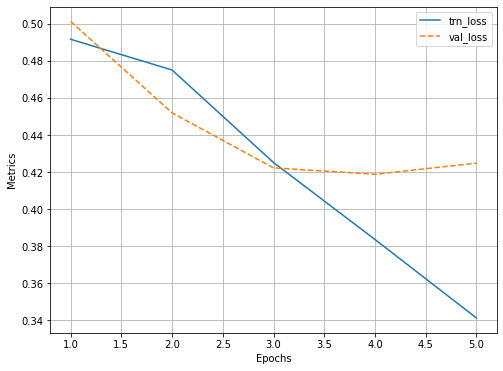

In [65]:
#Model loss evolution with epochs
log.plot_epochs(['trn_loss','val_loss'])

In [60]:
#Check the model with test images
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array(output['labels'].cpu().detach().numpy())
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()



In [61]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    #outputs = model(images)
    
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        #print(bbs)
        #print(confs)
        #print(labels)
        #info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5) #Show from pytorch snippets

NameError: name 'outputs' is not defined

# Saving the model in pth format

In [ ]:
torch.save(model.state_dict(), "model/model_default.pth")
print("Saved PyTorch Model State to model.pth")

# Reading the pth model and making inference with it

In [ ]:
model = get_model(num_classes= 2).to(device)
model.load_state_dict(torch.load("model/model_default.pth"))

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==1: break
    images = [im for im in images]
    print(images)
    with torch.no_grad():
        outputs = model(images)
    
    
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        #print(bbs)
        #print(confs)
        #print(labels)
        #info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5) #Show from pytorch snippets
    

# Training after freezing all the backbone

In [ ]:
#Freezing the backbone layers
layer_counter = 0
for (name, module) in model.named_children():
    if name == 'backbone':
        for layer in module.children():
            for param in layer.parameters():
                param.requires_grad = False
            
            print('Layer "{}" in module "{}" was frozen!'.format(layer_counter, name))
            print(layer)
            layer_counter+=1

#Updating the optimizer 
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
